In [196]:
!pip install p3_data

In [197]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [469]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [1012]:
# Load result files from Pavel's resuls from Dirt with his script test running for no_netty and better_batching
src_files = []

# Pavel's master on Dirt without p3_test_driver
#src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/master/100b/*.json']# 8 tests
#src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/master/10kb/*.json']# 6 tests

# Pavel's no_netty_lower_cpu on Dirt without p3_test_driver:
src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/no-netty-low-cpu/10kb/*.json']  # 6 tests
#src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/no-netty-low-cpu/100b/*.json'] # 8 tests

# Pavel's lower_cpu on Dirt without p3_test_driver:
#src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/low-cpu/10kb/*.json'] # 6 tests
#src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/low-cpu/100b/*.json'] # 8 tests

# Pavel's no_netty on Dirt without p3_test_driver:
src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/no-netty/10kb/*.json']
#src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/no-netty/100b/*.json']# 8 tests

# Pavel's better_batching on Dirt without p3_test_driver:
#src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/better-batching/10kb/*.json'] # 6 tests
#src_files += ['../../../../no_netty_comparison/28april-Dirt/pavels_results_29april_Dirt_cleared/better-batching/100b/*.json'] # 8 tests

raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 12 files...


In [1013]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '0.6.0-2361.f273314-SNAPSHOT'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [1014]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [1015]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [1016]:
# Show list of columns
clean_df.columns.values

array(['ansible', 'ansible_vars', 'aws-ec2', 'build', 'command_timed_out',
       'docker', 'driver', 'elapsed_sec', 'error', 'errors', 'exit_code',
       'git_commit', 'kubernetes', 'localWorker', 'max_test_attempts',
       'noop', 'numWorkers', 'omb_results', 'omb_workers', 'print_output',
       'record_utc', 'record_uuid', 'result_filename', 'run_as_test',
       'sequence_in_test_batch', 'size_of_test_batch', 'ssh_host',
       'ssh_identity_file', 'ssh_user', 'status_html', 'tarball',
       'terraform', 'terraform_show', 'test', 'test_attempt',
       'test_batch_uuid', 'test_desc', 'test_driver_log_filename',
       'test_driver_version', 'test_uuid', 'undeploy', 'utc_begin',
       'utc_end', 'loaded_filename', 'driverName',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic', 'testDurationMinutes', 'topics',
 

In [1017]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'pravegaVersion',
]

In [1018]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'utc_begin',    
]

In [1019]:
cols = param_cols + output_cols

In [1020]:
# View most recent results
clean_df[cols].tail(24).T

test_uuid,1topic_16partitions_10Kb_10000eps,1topic_16partitions_10Kb_20000eps,1topic_16partitions_10Kb_30000eps,1topic_1partition_10Kb_10000eps,1topic_1partition_10Kb_20000eps,1topic_1partition_10Kb_30000eps,1topic_16partitions_10Kb_10000eps,1topic_16partitions_10Kb_20000eps,1topic_16partitions_10Kb_30000eps,1topic_1partition_10Kb_10000eps,1topic_1partition_10Kb_20000eps,1topic_1partition_10Kb_30000eps
numWorkloadWorkers,2,2,2,2,2,2,2,2,2,2,2,2
topics,1,1,1,1,1,1,1,1,1,1,1,1
partitionsPerTopic,16,16,16,1,1,1,16,16,16,1,1,1
producersPerTopic,1,1,1,1,1,1,1,1,1,1,1,1
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,1,1,1,1,1,1,1,1,1,1,1,1
testDurationMinutes,2,2,2,2,2,2,2,2,2,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,b28d173,b28d173,b28d173,b28d173,b28d173,b28d173,b28d173,b28d173,b28d173,b28d173,b28d173,b28d173
pravegaVersion,no-netty-low-cpu,no-netty-low-cpu,no-netty-low-cpu,no-netty-low-cpu,no-netty-low-cpu,no-netty-low-cpu,no-netty,no-netty,no-netty,no-netty,no-netty,no-netty


In [1021]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [1022]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [1023]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['pravegaVersion']).size()

pravegaVersion
no-netty            6
no-netty-low-cpu    6
dtype: int64

In [1024]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
  #  driverName='Pravega',
  #  pravegaVersion='0.8.0-2508.30406cf',
#     pravegaVersion='0.6.0-2386.23b7340',
   # numWorkloadWorkers=2, 
    topics=1,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

12

In [1025]:
def latency_vs_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Publish Throughput (MB/s)'
    return result_df

In [1026]:
def plot_latency_vs_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    pravegaVersion =  df.pravegaVersion.iloc[0]
    plot_df = latency_vs_throughput_table(df)
    title = '%s on Dirt (Pavels results), Message Size %d, partitions: %d, 2min test' % (pravegaVersion, messageSize, partitionsPerTopic)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [1027]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    #producersPerTopic=1,
    partitionsPerTopic=16,
)

filter_dataframe: No matching records after filtering on messageSize=[100]


In [1028]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid


In [1029]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid
numWorkloadWorkers
topics
partitionsPerTopic
producersPerTopic
subscriptionsPerTopic
consumerPerSubscription
testDurationMinutes
keyDistributor
git_commit
pravegaVersion


In [1030]:
plot_latency_vs_throughput(filt_100_df)

AssertionError: 

In [ ]:
latency_vs_throughput_table(filt_100_df)

## Message Size 10 KB

In [1031]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10240,
    #producersPerTopic=1,
    partitionsPerTopic=16,
)

In [1032]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,1topic_16partitions_10Kb_10000eps,1topic_16partitions_10Kb_10000eps
numWorkloadWorkers,2,2
topics,1,1
partitionsPerTopic,16,16
producersPerTopic,1,1
subscriptionsPerTopic,1,1
consumerPerSubscription,1,1
testDurationMinutes,2,2
keyDistributor,NO_KEY,NO_KEY
git_commit,b28d173,b28d173
pravegaVersion,no-netty-low-cpu,no-netty


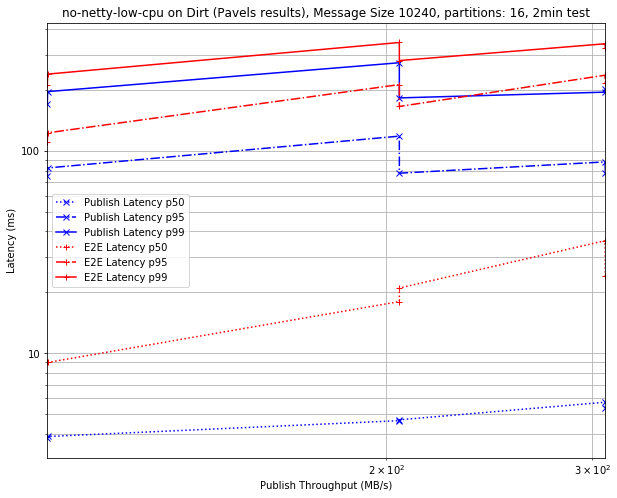

In [1033]:
plot_latency_vs_throughput(filt_10000_df)

In [1034]:
latency_vs_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
102.504902,3.815,75.162,171.521,9.0,111.0,211.000,1topic_16partitions_10Kb_10000eps
102.565677,3.874,82.437,196.585,9.0,123.0,240.000,1topic_16partitions_10Kb_10000eps
205.155479,4.639,118.424,273.155,18.0,213.0,344.001,1topic_16partitions_10Kb_20000eps
205.170754,4.685,77.656,183.047,21.0,166.0,280.001,1topic_16partitions_10Kb_20000eps
307.739365,5.722,88.312,195.426,36.0,237.0,339.001,1topic_16partitions_10Kb_30000eps
307.916722,5.368,77.897,201.453,24.0,216.0,323.001,1topic_16partitions_10Kb_30000eps


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [1035]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

filter_dataframe: No matching records after filtering on messageSize=[100]


0

In [1036]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

""
test_uuid


# Analyze Latency Distribution

In [1037]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

IndexError: single positional indexer is out-of-bounds

In [1038]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [1039]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [1040]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

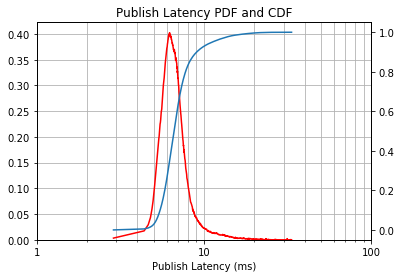

In [1041]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [1042]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

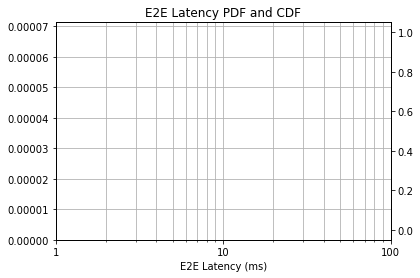

In [1043]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

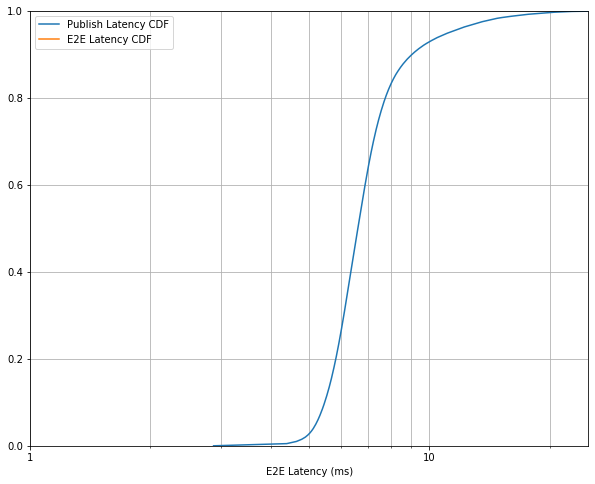

In [1044]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [1053]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    driverName='Pravega',
    #numWorkloadWorkers=4, 
    topics=1,
    testDurationMinutes=2,
    #size_of_test_batch=(2,1000), # between
    #aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=10240,
    #producersPerTopic=1,
    partitionsPerTopic=16,    
)
len(filt_df)
filt_df.iloc[0].pravegaVersion

'no-netty-low-cpu'

In [1054]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    pravegaVersion='no-netty',
)
len(filt1_df)
filt1_df.iloc[0]

ansible                                                                True
ansible_vars              {'bookkeeperVersion': '4.9.2', 'pravegaContain...
aws-ec2                                                                True
build                                                                 False
command_timed_out                                                     False
                                                ...                        
publishLatencyMs50Pct                                                 3.874
publishLatencyMs99Pct                                               196.585
endToEndLatencyMsAvg                                                25.8253
endToEndLatencyMs50Pct                                                    9
endToEndLatencyMs99Pct                                                  240
Name: 1topic_16partitions_10Kb_10000eps, Length: 112, dtype: object

In [1055]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    pravegaVersion='no-netty-low-cpu',
)
len(filt2_df)
filt2_df.iloc[0]

ansible                                                                True
ansible_vars              {'bookkeeperVersion': '4.9.2', 'pravegaContain...
aws-ec2                                                                True
build                                                                 False
command_timed_out                                                     False
                                                ...                        
publishLatencyMs50Pct                                                 3.815
publishLatencyMs99Pct                                               171.521
endToEndLatencyMsAvg                                                 23.882
endToEndLatencyMs50Pct                                                    9
endToEndLatencyMs99Pct                                                  211
Name: 1topic_16partitions_10Kb_10000eps, Length: 112, dtype: object

In [1056]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

,pravegaVersion
test_uuid,
1topic_16partitions_10Kb_10000eps,no-netty
1topic_16partitions_10Kb_10000eps,no-netty-low-cpu


In [1057]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    
    messageSize = filt1_df.messageSize.iloc[0]
    partitionsPerTopic = filt1_df.partitionsPerTopic.iloc[0]
    pravegaVersion1 =  filt1_df.pravegaVersion.iloc[0]
    pravegaVersion2 =  filt2_df.pravegaVersion.iloc[0]
    title = 'Comparison %s vs %s %db %dp 2min on Dirt (no p3)' % (pravegaVersion1, pravegaVersion2, messageSize, partitionsPerTopic)    
    #title = 'Comparison *master vs lower_cpu*: 100b 1p 2min on Dirt (no p3)'
    
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                title=title,
                color=color,
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

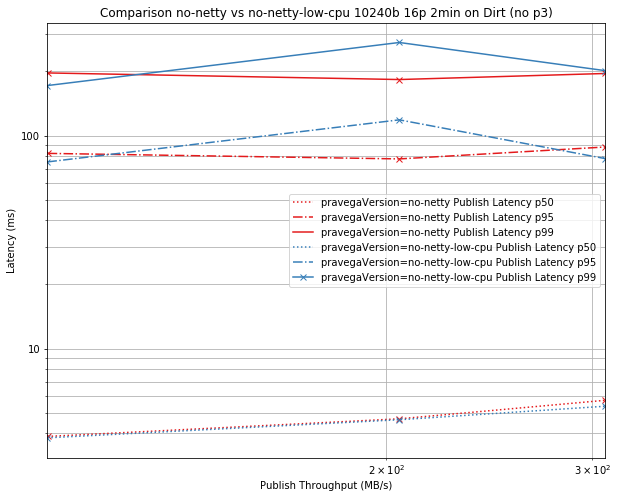

In [1058]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='Publish')

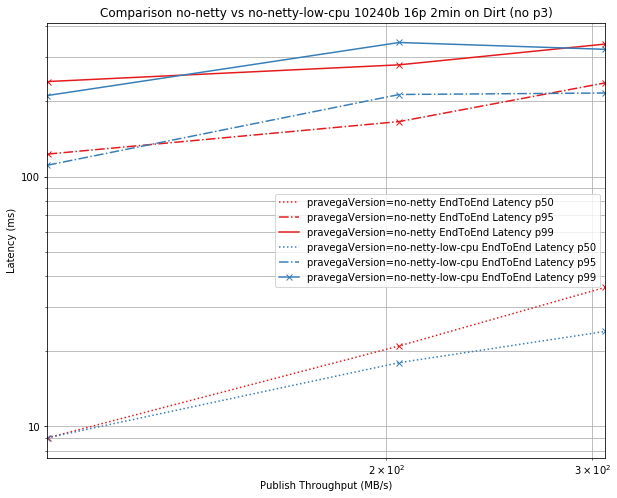

In [1059]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['pravegaVersion'], latencyMetric='EndToEnd')